In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from layers import disp_to_depth
from utils import readlines
from options import MonodepthOptions
import datasets
import networks
import datasets.aecai_scared_loader
import torchvision.transforms as transforms
import PIL.Image as pil
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1. generate predicitions

In [2]:
# set up paths
root_dir= "/home/cornelius/Documents/Bibliothek/ICL/IndependentStudyOption/scared_accurate_3ds"
save_path= "pred_disp/scared"
#options = MonodepthOptions()
#opt = opt.parse()

if os.path.exists(save_path)!=True:
    os.makedirs(save_path)

In [3]:
# load models
device = "cpu"
encoder_path = "./Model_ICRA/encoder.pth"
decoder_path = "./Model_ICRA/depth.pth"
encoder_dict = torch.load(encoder_path, map_location=device)

# load encoder
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(encoder.num_ch_enc, scales=range(4))
# load depth decoder
model_dict = encoder.state_dict()
encoder.load_state_dict({k: v for k, v in encoder_dict.items() if k in model_dict})
depth_decoder.load_state_dict(torch.load(decoder_path, map_location=device))

encoder.eval()
depth_decoder.eval()

DepthDecoder(
  (decoder): ModuleList(
    (0): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (2): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (3): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (4): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv

In [4]:
keyframes = 4
scared_d = [8, 9]
size = (encoder_dict['width'], encoder_dict['height'])
# run model on datasets 8 and 9
for i in (scared_d):
    for k in range(keyframes):
        # TODO: load data for eval!!!
        # Load image and preprocess
        left_img = pil.open("{}/dataset{}_keyframe{}/Left_Image_rect.png".format(root_dir, i, k)).convert('RGB')

        original_width, original_height = left_img.size
        left_img = left_img.resize(size, pil.LANCZOS)
        left_img = transforms.ToTensor()(left_img).unsqueeze(0)

        if torch.cuda.is_available():
            left_img = left_img.to(device)
            
        # predict
        with torch.no_grad():
            output = depth_decoder(encoder(left_img))

        pred_disparities = np.asarray(output[("disp", 0)])
        print('disparity output dataset {} keyframe {} complete!'.format(i, k))
        np.save('{}/dataset{}_keyframe{}_predicted_disparities.npy'.format(save_path, i, k), pred_disparities)

/tmp/ipykernel_82928/1964331458.py:12: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  left_img = left_img.resize(size, pil.LANCZOS)


disparity output dataset 8 keyframe 0 complete!
disparity output dataset 8 keyframe 1 complete!
disparity output dataset 8 keyframe 2 complete!
disparity output dataset 8 keyframe 3 complete!
disparity output dataset 9 keyframe 0 complete!
disparity output dataset 9 keyframe 1 complete!
disparity output dataset 9 keyframe 2 complete!
disparity output dataset 9 keyframe 3 complete!


# 2. eval

In [5]:
def sam_disp_to_depth(gt_disp, pred_disp, dataset_id):
    # hardcoded camera params
    if dataset_id == 9:
        b = 4.132568439900515
        f = 1110.2546425040427
    elif dataset_id == 8:
        b = 4.348277165573036
        f = 1112.709358269966
    
    # transfer to depth -- ask Sam again how he did it
    height, width = gt_disp.shape
    pred_disp = width * cv2.resize(pred_disp, (width, height), interpolation=cv2.INTER_LINEAR) #* 0.001
    mask = gt_disp > 0
    gt_depth = f * (b / 1000) / (gt_disp + (1. - mask))
    pred_depth = f * (b / 1000) / pred_disp
    
    return gt_depth, pred_depth, pred_disp

In [12]:
# choose if you want postprocessed error or not
pp = False
MIN_DEPTH = 1e-3 # TODO: which values to use ???
MAX_DEPTH = 150
keyframes = 4
scared_d = [8, 9]
size = (encoder_dict['width'], encoder_dict['height'])

# loop over all test data again
rmse_list, log_r_list, abs_rel_list, abs_mean_list = [], [], [], []
for d in scared_d:
    for k in range(keyframes):
        
        # load ground truth
        #gt_disparities = cv2.imread("{}/dataset{}_keyframe{}/left_disp_rect.png".format(root_dir, d, k), -1) #np.load('{}/dataset_{}_keyframe_{}_gt_disparities.npy'.format(pred_save_path, d, k))
        #gt_disparities = np.array(gt_disparities)
        #gt_depth = 1 / gt_disparities
        gt_depth = cv2.imread("{}/dataset{}_keyframe{}/left_depth_map_rect.bmp".format(root_dir, d, k), -1)
        
        # load predicted disparities
        if pp:
            pred_disparities= np.load('{}/dataset{}_keyframe{}_predicted_disparities_pp.npy'.format(save_path, d, k))
        else:
            pred_disparities= np.load('{}/dataset{}_keyframe{}_predicted_disparities.npy'.format(save_path, d, k))
        
        # resize
        gt_height, gt_width = gt_depth.shape[:2]
        pred_disp = cv2.resize(pred_disparities[0,0], (gt_width, gt_height))
        
        # convert disparities to depth maps
        #gt_dept, _ = disp_to_depth(gt_disparities, MIN_DEPTH, MAX_DEPTH)
        _, pred_depth = disp_to_depth(pred_disp, MIN_DEPTH, MAX_DEPTH)
        
        print(gt_depth.min(), gt_depth.max())
        
        # mask the boundaries
        mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)
        pred_depth = pred_depth[mask]
        gt_depth = gt_depth[mask]
        
        # median scaling
        #ratio = np.median(gt_depth) / np.median(pred_depth)
        #pred_depth *= ratio
        
        # mask the points that we want to ignore
        pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
        pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
        
        # compute errors
        thresh = np.maximum((gt_depth / pred_depth), (pred_depth / gt_depth))
        a1 = (thresh < 1.25     ).mean()
        a2 = (thresh < 1.25 ** 2).mean()
        a3 = (thresh < 1.25 ** 3).mean()

        rmse = (gt_depth - pred_depth) ** 2
        rmse = np.sqrt(rmse.mean())
        rmse_log = (np.log(gt_depth) - np.log(pred_depth)) ** 2
        rmse_log = np.sqrt(rmse_log.mean())
        abs_rel = np.mean(np.abs(gt_depth - pred_depth) / gt_depth)
        sq_rel = np.mean(((gt_depth - pred_depth) ** 2) / gt_depth)
        mean_abs = mean_absolute_error(gt_depth, pred_depth)

        # append
        rmse_list.append(rmse); log_r_list.append(rmse_log); abs_rel_list.append(abs_rel); abs_mean_list.append(mean_abs)
        print(f"keyframe {k}, dataset {d}: rmse={round(rmse, 2)}, rmse_log={round(rmse_log, 2)}, abs rel={round(abs_rel, 2)}, mean abs={round(mean_abs,2)}")
        
        
print("")
print("FINAL RESULTS")
print(f"rmse={round(np.mean(rmse), 4)}, rmse_log={round(np.mean(rmse_log),4)}, abs rel={round(np.mean(abs_rel),4)}, mean abs={round(np.mean(mean_abs),4)}")
#plt.colorbar();

0 255
keyframe 0, dataset 8: rmse=112.83999633789062, rmse_log=10.489999771118164, abs rel=1.0, mean abs=112.44000244140625
0 255
keyframe 1, dataset 8: rmse=75.38999938964844, rmse_log=10.069999694824219, abs rel=1.0, mean abs=74.94999694824219
0 255
keyframe 2, dataset 8: rmse=56.31999969482422, rmse_log=9.800000190734863, abs rel=1.0, mean abs=56.119998931884766
0 255
keyframe 3, dataset 8: rmse=60.040000915527344, rmse_log=9.859999656677246, abs rel=1.0, mean abs=59.880001068115234
0 255
keyframe 0, dataset 9: rmse=92.5, rmse_log=10.220000267028809, abs rel=1.0, mean abs=89.81999969482422
0 119
keyframe 1, dataset 9: rmse=53.779998779296875, rmse_log=9.619999885559082, abs rel=1.0, mean abs=52.70000076293945
0 255
keyframe 2, dataset 9: rmse=60.959999084472656, rmse_log=9.859999656677246, abs rel=1.0, mean abs=60.27000045776367
0 206
keyframe 3, dataset 9: rmse=38.66999816894531, rmse_log=9.350000381469727, abs rel=1.0, mean abs=37.040000915527344

FINAL RESULTS
rmse=38.66970062255

In [11]:
# plot gt
plt.imshow(gt_depth.reshape(pred_disp.shape), cmap="magma")
plt.colorbar();

ValueError: cannot reshape array of size 853299 into shape (1024,1280)

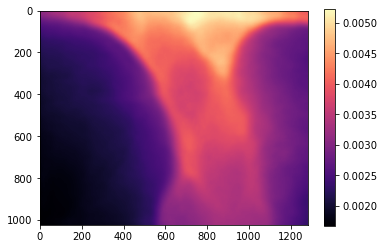

In [9]:
# plot difference image for last one
_, pred_depth = disp_to_depth(pred_disp, MIN_DEPTH, MAX_DEPTH)
plt.imshow(pred_depth, cmap='magma')
plt.colorbar();

# 3. hamlyn

### dataloader

In [4]:
import os
from PIL import Image, ImageFile
from glob import glob
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
ImageFile.LOAD_TRUNCATED_IMAGES = True
from loss import MonodepthLoss

class HamlynLoader(Dataset):
    def __init__(self, root_dir, split, transform=None, n_val_samples=1000):
        if split =='train' or split=='val':
            self.left_paths_all= sorted(glob('{}/train/image_0/*.png'.format(root_dir)))
            self.right_paths_all= sorted(glob('{}/train/image_1/*.png'.format(root_dir)))

            if split=='train':
                self.left_paths= self.left_paths_all[0:len(self.left_paths_all)-n_val_samples]
                self.right_paths= self.right_paths_all[0:len(self.right_paths_all)-n_val_samples]
    
            elif split=='val':
                self.left_paths= self.left_paths_all[len(self.left_paths_all)-n_val_samples::]
                self.right_paths= self.right_paths_all[len(self.right_paths_all)-n_val_samples::]

        elif split=='test':
            self.left_paths= sorted(glob('{}/test/image_0/*.png'.format(root_dir)))
            self.right_paths= sorted(glob('{}/test/image_1/*.png'.format(root_dir)))
        
        self.transform = transform

        
    def __getitem__(self, idx):
        left_image = Image.open(self.left_paths[idx]).convert('RGB')
        right_image = Image.open(self.right_paths[idx]).convert('RGB')

        if self.transform:
            left_image = self.transform(left_image)
            right_image = self.transform(right_image)
        
        sample = {'left_image': left_image, 'right_image': right_image}
        return sample#, left_disp


    def __len__(self):
        return len(self.left_paths)

## load data

In [5]:
size = (encoder_dict['width'], encoder_dict['height'])
root_dir = "../daVinci" 
transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor()
            ])

dataset = HamlynLoader(root_dir, "test", transform=transform)
data_loader = DataLoader(dataset, batch_size=1,
                        shuffle=False, num_workers=1,
                        pin_memory=False)

save_path= './pred_disp/hamlyn/'
if os.path.exists(save_path)!=True:
    os.makedirs(save_path)
    

In [6]:
def apply_disparity(img, disp):
    """
    this rewarps the image based on the disparities
    """
        batch_size, _, height, width = img.size()

        # Original coordinates of pixels
        x_base = torch.linspace(0, 1, width).repeat(batch_size,
                    height, 1).type_as(img)
        y_base = torch.linspace(0, 1, height).repeat(batch_size,
                    width, 1).transpose(1, 2).type_as(img)

        # Apply shift in X direction
        x_shifts = disp[:, 0, :, :]  # Disparity is passed in NCHW format with 1 channel
        flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)
        # In grid_sample coordinates are assumed to be between -1 and 1
        output = F.grid_sample(img, 2*flow_field - 1, mode='bilinear', padding_mode='zeros')
        return output

In [10]:
import pytorch_ssim
#from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import torch.nn.functional as F
window_size=11
disp_scale = 1.

left_ssim, right_ssim=[],[]
for i, data in enumerate(data_loader):
    left_img= data['left_image']
    right_img= data['right_image']
    
    left_img= left_img.to(device)
    right_img= right_img.to(device)
    
    # do a forward pass:
    with torch.no_grad():
        output_left = depth_decoder(encoder(left_img))
        output_right = depth_decoder(encoder(right_img))

    # get disparities
    left_disparities = output_left[("disp", 0)]#disp_to_depth(output_left[("disp", 0)], MIN_DEPTH, MAX_DEPTH)
    right_disparities = output_right[("disp", 0)]#disp_to_depth(output_right[("disp", 0)], MIN_DEPTH, MAX_DEPTH)
    
    # resize not necessary because we dont compare to ground truth
    
    # rewarp images
    left_pred = apply_disparity(right_img, -left_disparities)[0,:,:,:]
    right_pred = apply_disparity(left_img, right_disparities)[0,:,:,:]
    
    # compute errors
    ssi_left = pytorch_ssim.ssim(left_img, left_pred.unsqueeze(0), window_size)
    ssi_right = pytorch_ssim.ssim(right_img, right_pred.unsqueeze(0), window_size)
    left_ssim.append(ssi_left.item())
    right_ssim.append(ssi_right.item())
    
    if i%50==0 and i > 49:
        print(i)
    if i==200:
        break

/home/cornelius/anaconda3/envs/deepLearn/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


50
100
150
200


In [11]:
print('left results:', np.mean(left_ssim), np.std(left_ssim))
print('right results:', np.mean(right_ssim), np.std(right_ssim))

left results: 0.19701632308722727 0.03204970020095327
right results: 0.23758255642148393 0.03407989120977607


left_disp_006523


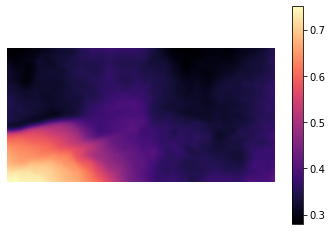

gt_left_img_006523


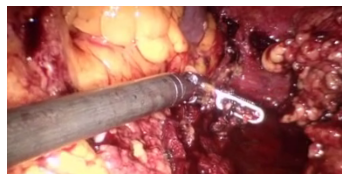

pred_left_img


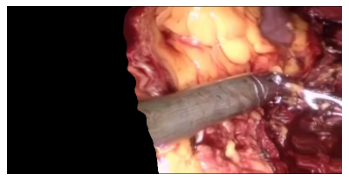

left_disp_006433


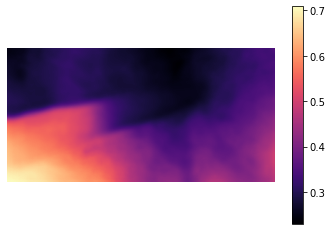

gt_left_img_006433


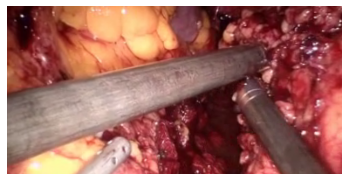

pred_left_img


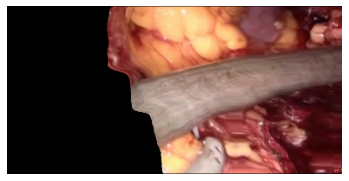

left_disp_005914


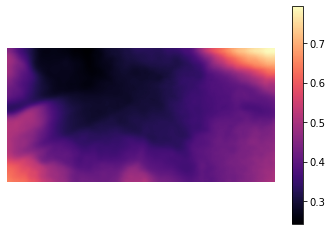

gt_left_img_005914


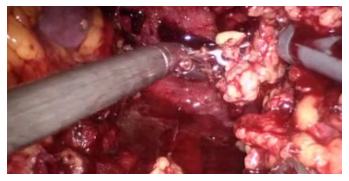

pred_left_img


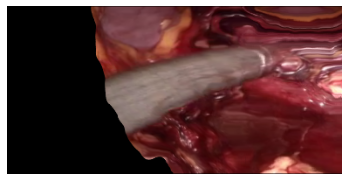

left_disp_003649


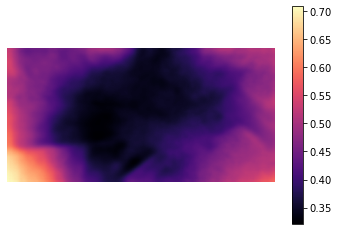

gt_left_img_003649


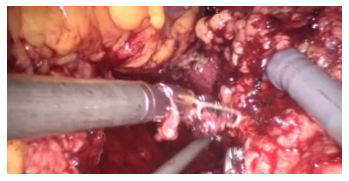

pred_left_img


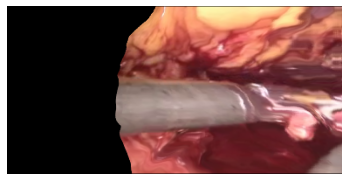

left_disp_003454


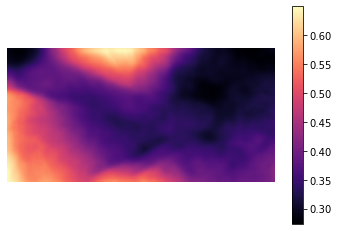

gt_left_img_003454


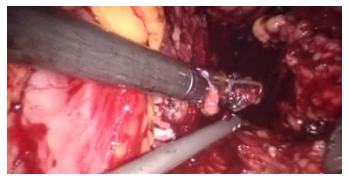

pred_left_img


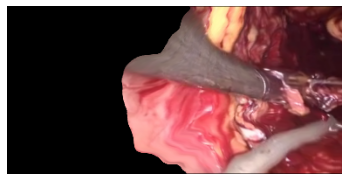

left_disp_003115


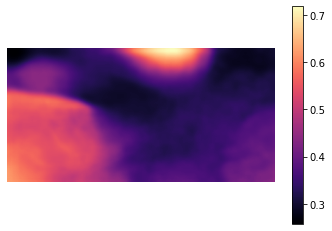

gt_left_img_003115


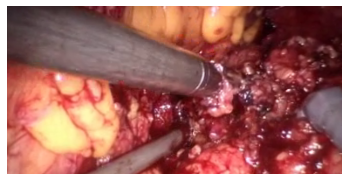

pred_left_img


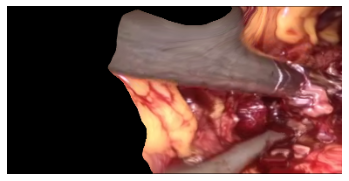

left_disp_002822


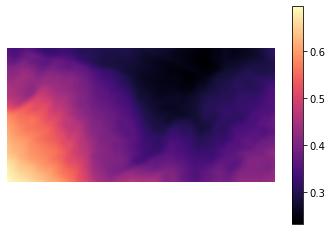

gt_left_img_002822


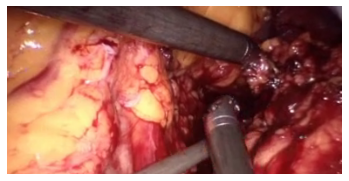

pred_left_img


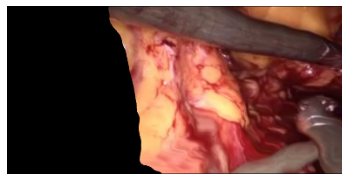

left_disp_002587


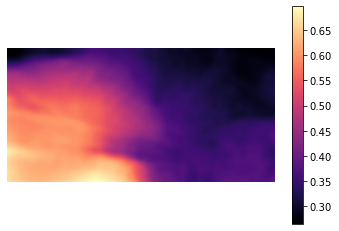

gt_left_img_002587


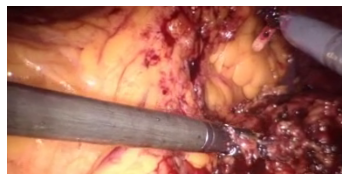

pred_left_img


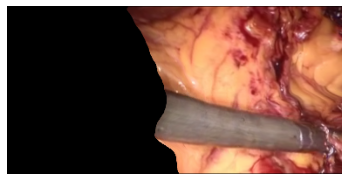

left_disp_002473


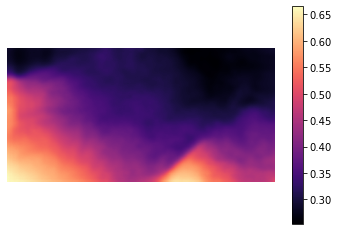

gt_left_img_002473


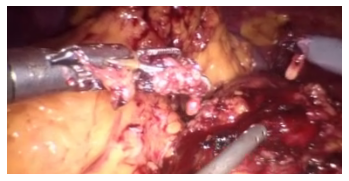

pred_left_img


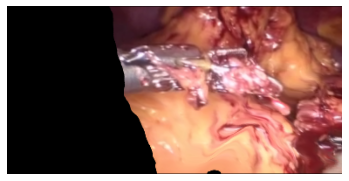

left_disp_002254


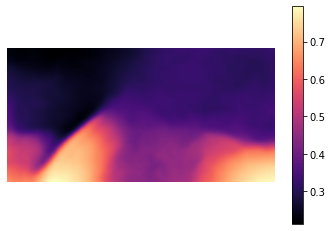

gt_left_img_002254


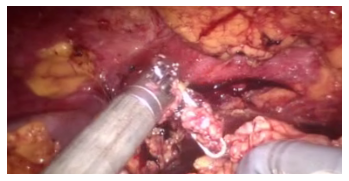

pred_left_img


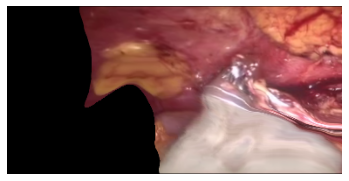

left_disp_002012


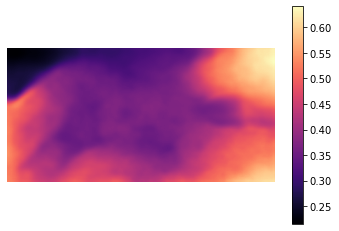

gt_left_img_002012


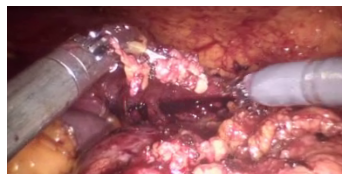

pred_left_img


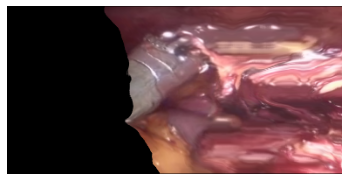

left_disp_001850


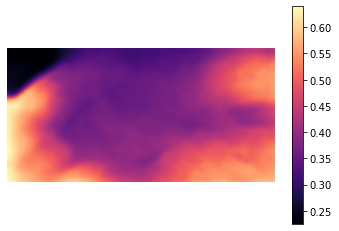

gt_left_img_001850


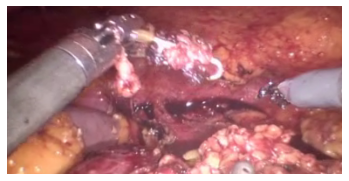

pred_left_img


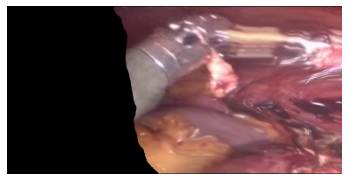

left_disp_001309


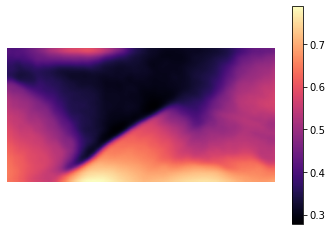

gt_left_img_001309


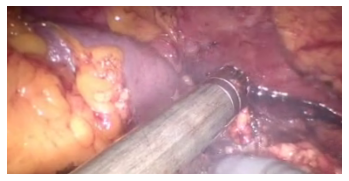

pred_left_img


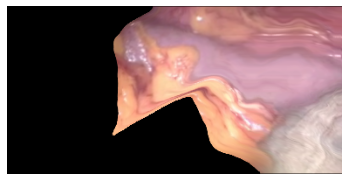

left_disp_001308


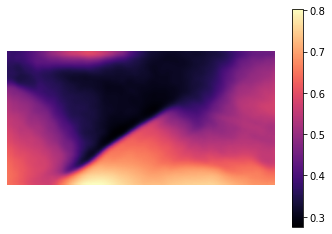

gt_left_img_001308


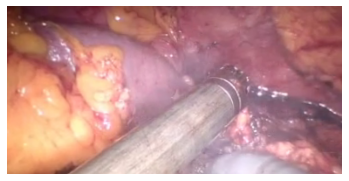

pred_left_img


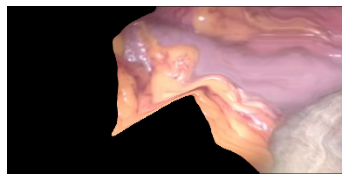

left_disp_001198


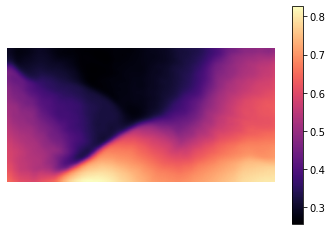

gt_left_img_001198


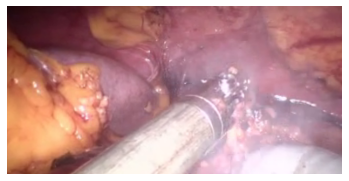

pred_left_img


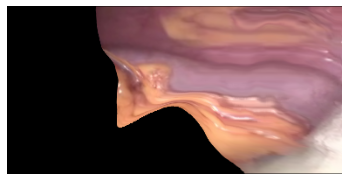

In [33]:
import torchvision.transforms as transforms
hamlyn_files=['006523', '006433', '005914', '003649', '003454', '003115', '002822', '002587', '002473', '002254', '002012', '001850', '001309', '001308', '001198']
convert_tensor = transforms.ToTensor()
for i in hamlyn_files:
    left_file_dir= '{}/test/image_0/{}.png'.format(root_dir, i)
    right_file_dir= '{}/test/image_1/{}.png'.format(root_dir, i)
    left_img= convert_tensor(Image.open(left_file_dir))#read_img(left_file_dir)
    left_img=left_img.unsqueeze(0)
    right_img= convert_tensor(Image.open(right_file_dir))#read_img(right_file_dir)
    right_img= right_img.unsqueeze(0)
    
    # do a forward pass:
    with torch.no_grad():
        output_left = depth_decoder(encoder(left_img))
        output_right = depth_decoder(encoder(right_img))

    left_disparities = output_left[("disp", 0)]#disp_to_depth(output_left[("disp", 0)], MIN_DEPTH, MAX_DEPTH)
    right_disparities = output_right[("disp", 0)]#disp_to_depth(output_right[("disp", 0)], MIN_DEPTH, MAX_DEPTH)
    
    left_pred = apply_disparity(right_img, -left_disparities)[0,:,:,:]
    right_pred = apply_disparity(left_img, right_disparities)[0,:,:,:]
    
    print('left_disp_{}'.format(i))
    #a[0,1].set_title('left_disp')
    left_disp_resized= cv2.resize(np.squeeze(np.transpose(left_disparities[0,:,:,:].cpu().detach().numpy(), (1, 2, 0))), (384, 192))
    plt.axis('off')
    plt.imshow(left_disp_resized, cmap="magma")#, vmin=0.02, vmax=0.18)
    plt.colorbar()
    plt.show()

    print('gt_left_img_{}'.format(i))
    left_img_resized= cv2.resize(np.transpose(left_img.squeeze(0).cpu().detach().numpy(),(1, 2, 0)), (384, 192))
    plt.axis('off')
    plt.imshow(left_img_resized)
    plt.show()

    print('pred_left_img')
    plt.axis('off')
    plt.imshow(cv2.resize(np.transpose(left_pred.cpu().detach().numpy(),(1, 2, 0)), (384, 192)))
    plt.show()
    